# 1. Imports & Setup

In [1]:
# DATA_PATH = r"C:\Users\tengh\IMDB Dataset.csv"
# IN_PATH  = "dataset/IMDB Dataset.csv"      # Kaggle file
# OUT_PATH = "dataset/imdb_clean_split.csv"  # Shared artifact
# %pip install lxml

IN_PATH  = r"dataset/IMDB Dataset.csv"
OUT_PATH = r"dataset/imdb_clean_split.csv"

# --- Setup ---
import re, unicodedata, hashlib, html, string, pandas as pd, numpy as np
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split

# 2. Clean Text

In [2]:
import re, unicodedata, hashlib, html, string, pandas as pd, numpy as np
from bs4 import BeautifulSoup

def clean_text(x):
    if not isinstance(x, str):
        return ""
    # Unescape & strip HTML
    x = html.unescape(x)
    x = BeautifulSoup(x, "lxml").get_text(separator=" ")

    # Unicode normalize + unify curly quotes to straight ones
    x = unicodedata.normalize("NFKC", x)
    x = x.replace("“", "'").replace("”", "'").replace("‘", "'").replace("’", "'").replace('"', "'")

    # Neutralize obvious artifacts
    x = re.sub(r"(https?://\S+)|(\w+\.\w+/\S+)", " ", x)
    x = re.sub(r"\b[\w\.-]+@[\w\.-]+\.\w+\b", " ", x)

    # runs of 3+ asterisks → single *
    x = re.sub(r"\{2,}", "", x)

    # collapse any run of -, – or — to a single em dash, with spacing
    x = re.sub(r"\s*[-–—]{2,}\s*", " — ", x)

    # "" → "   and   '' → '
    x = re.sub(r'([\'\"])\1+', r'\1', x)  # collapse immediate repeats
    # also clean cases with whitespace between repeated quotes: "  " → "
    x = re.sub(r'([\'"])\s+\1', r'\1', x)

    # cap !!!!! or ????? at two; dots at an ellipsis
    x = re.sub(r"([!?])\1{2,}", r"\1\1", x)   # keep at most two
    x = re.sub(r"\.{3,}", "…", x)

    # 5) Remove control chars & collapse whitespace
    x = re.sub(r"[\u0000-\u001F\u007F]", " ", x)
    x = re.sub(r"\s+", " ", x).strip()
    return x

df = pd.read_csv(IN_PATH)  # columns: review, sentiment
df["review_clean"] = df["review"].apply(clean_text)
df["label"] = (df["sentiment"].str.lower() == "positive").astype(int)

# drop null/empty data first
df = df.dropna(subset=['review_clean']).copy()  # drop rows where review_clean is null
# deduplicate (after cleaning) - keep first occurrence
def row_key(s): return hashlib.sha1(s.encode("utf-8")).hexdigest()
df["dup_key"] = df["review_clean"].apply(row_key)
df = df.drop_duplicates(subset=["dup_key"], keep='first').drop(columns=["dup_key"]).reset_index(drop=True)

from sklearn.model_selection import train_test_split

X = df["review_clean"].values
y = df["label"].values

# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Second split: from the 80%, split into 70% train (87.5% of temp) and 10% val (12.5% of temp)
# 0.125 = 10% / 80% (to get 10% of original data)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=42
)

# Create split column
df["split"] = "train"  # default
df.loc[df["review_clean"].isin(X_test), "split"] = "test"
df.loc[df["review_clean"].isin(X_val), "split"] = "val"

# basic EDA
print(df["split"].value_counts())
print(df["label"].value_counts())

df["n_chars"] = df["review_clean"].str.len()
df["n_words"] = df["review_clean"].str.split().apply(len)
print(df[["n_chars","n_words"]].describe(percentiles=[.5,.75,.9,.95,.99]))

df = df.rename(columns={"review_clean":"text"})
df[["text","label","split"]].to_csv(OUT_PATH, index=False)
print("Saved:", OUT_PATH)

split
train    34704
test      9916
val       4958
Name: count, dtype: int64
label
1    24882
0    24696
Name: count, dtype: int64
            n_chars       n_words
count  49578.000000  49578.000000
mean    1286.624249    229.274013
std      972.995822    169.952820
min       32.000000      4.000000
50%      954.000000    172.000000
75%     1560.000000    278.000000
90%     2532.000000    448.000000
95%     3334.000000    585.150000
99%     5100.460000    898.230000
max    13593.000000   2459.000000
Saved: dataset/imdb_clean_split.csv


In [3]:
%pip install nltk

  Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# === Apply NB-friendly preprocessing to the saved CSV ===
import re, html, string, time, pandas as pd, nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# 0) Make sure NLTK data is available
def _ensure_nltk():
    try: nltk.data.find('tokenizers/punkt')
    except LookupError: nltk.download('punkt')
    try: nltk.data.find('corpora/stopwords')
    except LookupError: nltk.download('stopwords')
    try: nltk.data.find('corpora/wordnet')
    except LookupError: nltk.download('wordnet')
    try: nltk.data.find('corpora/omw-1.4')
    except LookupError: nltk.download('omw-1.4')
_ensure_nltk()

# 1) Contractions map (extend if you like)
CONTRACTIONS = {
    "aren't":"are not","can't":"cannot","couldn't":"could not","didn't":"did not",
    "doesn't":"does not","don't":"do not","hadn't":"had not","hasn't":"has not",
    "haven't":"have not","he's":"he is","she's":"she is","it's":"it is","that's":"that is",
    "there's":"there is","what's":"what is","who's":"who is","won't":"will not",
    "wouldn't":"would not","shouldn't":"should not","isn't":"is not","i'm":"i am",
    "we're":"we are","they're":"they are","i've":"i have","we've":"we have","they've":"they have",
    "i'll":"i will","we'll":"we will","they'll":"they will","i'd":"i would","we'd":"we would","they'd":"they would",
    "you're":"you are","you've":"you have","you'll":"you will","you'd":"you would",
    "could've":"could have","should've":"should have","would've":"would have","mustn't":"must not",
}
_keys = sorted(CONTRACTIONS.keys(), key=len, reverse=True)
RE_CONTRACTIONS = re.compile(r"\b(" + "|".join(map(re.escape, _keys)) + r")\b")
def expand_contractions(text: str) -> str:
    return RE_CONTRACTIONS.sub(lambda m: CONTRACTIONS[m.group(0)], text)

# 2) Precompiled regexes used here
RE_DIGITS = re.compile(r"\d+")
RE_PUNCT  = re.compile(f"[{re.escape(string.punctuation)}]")

# 3) Stopwords but KEEP negators (important for NB)
STOP_WORDS = set(stopwords.words("english"))
for neg in ("not","no","nor"):
    STOP_WORDS.discard(neg)

LEMMATIZER = WordNetLemmatizer()

def preprocess_text_on_cleaned(text: str) -> str:
    """
    Apply on 'text' from your saved CSV (already cleaned by clean_text).
    Adds: lowercase, contractions expansion, digits/punct strip, tokenization,
    stopword filtering (negators kept), lemmatization.
    """
    if not isinstance(text, str):
        return ""
    t = text.lower()
    t = expand_contractions(t)
    t = RE_DIGITS.sub(" ", t)
    t = RE_PUNCT.sub(" ", t)
    t = re.sub(r"\s+", " ", t).strip()

    tokens = nltk.word_tokenize(t)
    cleaned = [LEMMATIZER.lemmatize(tok) for tok in tokens
               if tok.isalpha() and len(tok) >= 2 and tok not in STOP_WORDS]
    return " ".join(cleaned)

# 4) Load your saved CSV (produced in the previous cell)
df = pd.read_csv(OUT_PATH)  # must contain columns: text, label, split
assert {"text","label","split"}.issubset(df.columns), "Expected columns text,label,split."

# 5) Apply the NB-friendly preprocessing
t0 = time.time()
df["text_nb"] = df["text"].astype(str).map(preprocess_text_on_cleaned)
print(f"Preprocessed {len(df)} rows in {time.time()-t0:.2f}s")

# 6) Drop rows that became empty after aggressive cleaning (rare but safe)
before = len(df)
df = df[df["text_nb"].str.len() > 0].copy()
print(f"Dropped {before - len(df)} empty rows. Remaining: {len(df)}")

[nltk_data] Downloading package wordnet to C:\Users\Vin
[nltk_data]     Sen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Vin
[nltk_data]     Sen\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Preprocessed 49578 rows in 89.63s
Dropped 0 empty rows. Remaining: 49578


# TF-IDF

In [5]:
# --- Step 1: Load cleaned + split dataset created by your code above ---
import pandas as pd

df2 = df

# Sanity checks
required_cols = {"label", "split"}
missing = required_cols - set(df2.columns)
assert not missing, f"Missing columns: {missing}"

# Choose which text column to use
TEXT_COL = "text_nb" if "text_nb" in df2.columns else "text"
assert TEXT_COL in df2.columns, "Neither 'text_nb' nor 'text' was found."

# Create split DataFrames
train_df = df2[df2['split'] == 'train'].copy()
val_df   = df2[df2['split'] == 'val'].copy()
test_df  = df2[df2['split'] == 'test'].copy()

X_train, y_train = train_df['text'].values, train_df['label'].values
X_val,   y_val   = val_df['text'].values,   val_df['label'].values
X_test,  y_test  = test_df['text'].values,  test_df['label'].values


# --- Pipeline: TF-IDF → MultinomialNB (auto-tuned to your TEXT_COL) ---
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

if TEXT_COL == "text_nb":
    tfidf = TfidfVectorizer(
        lowercase=False,          # already lowercased
        stop_words=None,          # stopwords already removed (negators preserved)
        token_pattern=r"[a-z]+",  # our NB text contains only a–z tokens
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95,
        sublinear_tf=True
    )
else:
    # Negation-aware stopwords (keep 'not', 'no', 'nor')
    custom_stop = set(ENGLISH_STOP_WORDS)
    for neg in ("not", "no", "nor"):
        custom_stop.discard(neg)

    tfidf = TfidfVectorizer(
        lowercase=True,
        stop_words=list(custom_stop),
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95,
        sublinear_tf=True
    )

baseline_pipe = Pipeline([
    ("tfidf", tfidf),
    ("nb", MultinomialNB(alpha=0.5))
])

baseline_pipe.fit(X_train, y_train)

# Validate
val_pred = baseline_pipe.predict(X_val)
print("=== Validation ===")
print("Accuracy:", accuracy_score(y_val, val_pred))
print(classification_report(y_val, val_pred, target_names=["negative","positive"], digits=4))

# Test
test_pred = baseline_pipe.predict(X_test)
print("\n=== Test ===")
print("Accuracy:", accuracy_score(y_test, test_pred))
print(classification_report(y_test, test_pred, target_names=["negative","positive"], digits=4))


=== Validation ===
Accuracy: 0.8864461476401775
              precision    recall  f1-score   support

    negative     0.8761    0.8992    0.8875      2470
    positive     0.8972    0.8738    0.8854      2488

    accuracy                         0.8864      4958
   macro avg     0.8867    0.8865    0.8864      4958
weighted avg     0.8867    0.8864    0.8864      4958


=== Test ===
Accuracy: 0.891286809197257
              precision    recall  f1-score   support

    negative     0.8848    0.8988    0.8917      4939
    positive     0.8979    0.8839    0.8908      4977

    accuracy                         0.8913      9916
   macro avg     0.8914    0.8913    0.8913      9916
weighted avg     0.8914    0.8913    0.8913      9916



# Hyperparameter tuning (simple, fast grid)

In [6]:
# --- Step 3: Grid search for better settings (fast) ---
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import numpy as np

X_trval = pd.concat([train_df['text'], val_df['text']], axis=0)
y_trval = np.concatenate([y_train, y_val], axis=0)

pipe = Pipeline([
    ('tfidf', TfidfVectorizer(
        lowercase=True,
        stop_words='english',
        sublinear_tf=True
    )),
    ('nb', MultinomialNB())
])

param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__min_df': [2,3,5],
    'tfidf__max_df': [0.9, 0.95, 1.0],
    'nb__alpha': [0.1, 0.5, 1.0, 2.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='f1_macro',      # matches many rubrics that want macro-F1
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_trval, y_trval)
print("Best params:", grid.best_params_)
print("Best CV macro-F1:", grid.best_score_)
best_pipe = grid.best_estimator_


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best params: {'nb__alpha': 0.5, 'tfidf__max_df': 0.9, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Best CV macro-F1: 0.8814429678677549


# Retrain the best pipeline on train+val and evaluate on test

In [7]:
# --- Step 4: Final training on train+val, test evaluation ---
best_pipe.fit(X_trval, y_trval)

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)

test_pred = best_pipe.predict(X_test)

acc = accuracy_score(y_test, test_pred)
prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
    y_test, test_pred, average='weighted', zero_division=0
)

print("=== Final Test Set Metrics (Weighted) ===")
print(f"Accuracy        : {acc:.4f}")
print(f"Precision (Wgt) : {prec_w:.4f}")
print(f"Recall (Wgt)    : {rec_w:.4f}")
print(f"F1 (Weighted)   : {f1_w:.4f}")

# (Optional) Per-class report still useful even if headline is weighted F1
print("\nClassification report (per class + macro/weighted rows):")
print(classification_report(
    y_test, test_pred,
    target_names=['negative','positive'], digits=4, zero_division=0
))

cm = confusion_matrix(y_test, test_pred)
print("\nConfusion Matrix (rows=true, cols=pred):\n", cm)


=== Final Test Set Metrics (Weighted) ===
Accuracy        : 0.8853
Precision (Wgt) : 0.8854
Recall (Wgt)    : 0.8853
F1 (Weighted)   : 0.8853

Classification report (per class + macro/weighted rows):
              precision    recall  f1-score   support

    negative     0.8891    0.8795    0.8843      4939
    positive     0.8817    0.8911    0.8864      4977

    accuracy                         0.8853      9916
   macro avg     0.8854    0.8853    0.8853      9916
weighted avg     0.8854    0.8853    0.8853      9916


Confusion Matrix (rows=true, cols=pred):
 [[4344  595]
 [ 542 4435]]


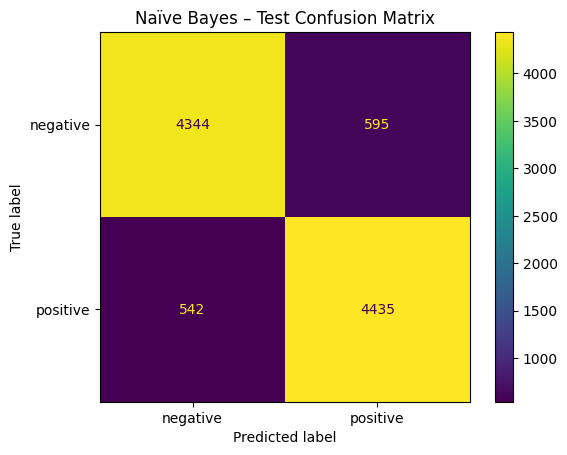

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative','positive'])
disp.plot(values_format='d')
plt.title("Naïve Bayes – Test Confusion Matrix")
plt.show()

# Save model

In [9]:
# --- Step 6: Save model ---
import joblib
MODEL_PATH = "models/nb/nb-sentiment.joblib"
joblib.dump(best_pipe, MODEL_PATH)
print("Saved model to:", MODEL_PATH)


Saved model to: models/nb/nb-sentiment.joblib


# Inference helper: predict on new reviews

In [10]:
# --- Step 7: Inference helper ---
import joblib

# Load (if in a fresh kernel, or skip if 'best_pipe' is in memory)
nb_pipe = joblib.load(MODEL_PATH)

id2label = {0: "negative", 1: "positive"}

def predict_reviews(texts):
    """texts: list[str] or a single str"""
    if isinstance(texts, str):
        texts = [texts]
    preds = nb_pipe.predict(texts)
    probs = nb_pipe.predict_proba(texts)
    return [
        {
            "text": t,
            "label_id": int(p),
            "label": id2label[int(p)],
            "prob_positive": float(pr[1]),
            "prob_negative": float(pr[0])
        }
        for t, p, pr in zip(texts, preds, probs)
    ]

# Try a few examples
examples = [
    "Absolutely loved it. The acting and the story were fantastic!",
    "What a waste of time. Boring and poorly written.",
]
for out in predict_reviews(examples):
    print(out)


{'text': 'Absolutely loved it. The acting and the story were fantastic!', 'label_id': 1, 'label': 'positive', 'prob_positive': 0.8655613946803808, 'prob_negative': 0.13443860531961746}
{'text': 'What a waste of time. Boring and poorly written.', 'label_id': 0, 'label': 'negative', 'prob_positive': 0.015093113113835217, 'prob_negative': 0.9849068868861653}


In [ ]:
from huggingface_hub import HfApi
import os

api = HfApi(token=os.getenv("HF_TOKEN"))
api.upload_folder(
    folder_path=r"D:\ai-app\models\nb",
    repo_id="noobrs/nb-movie-sentiment",
    repo_type="model",
)

d:\ai-app\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
nb-sentiment.joblib: 100%|██████████| 28.2M/28.2M [00:05<00:00, 4.82MB/s]


CommitInfo(commit_url='https://huggingface.co/noobrs/nb-movie-sentiment/commit/15c0a8a30977c9d0466cdb92d76a71799647ffb3', commit_message='Upload folder using huggingface_hub', commit_description='', oid='15c0a8a30977c9d0466cdb92d76a71799647ffb3', pr_url=None, repo_url=RepoUrl('https://huggingface.co/noobrs/nb-movie-sentiment', endpoint='https://huggingface.co', repo_type='model', repo_id='noobrs/nb-movie-sentiment'), pr_revision=None, pr_num=None)

In [4]:
from huggingface_hub import hf_hub_download
import joblib

SIDE_REPO = "noobrs/nb-movie-sentiment"  # your repo

def load_nb():
    try:
        nb_path = hf_hub_download(SIDE_REPO, filename="nb-sentiment.joblib")
        return joblib.load(nb_path)
    except Exception as e:
        return None

nb = load_nb()
id2label = {0: "negative", 1: "positive"}

def predict_reviews(texts):
    """texts: list[str] or a single str"""
    if isinstance(texts, str):
        texts = [texts]
    preds = nb.predict(texts)
    probs = nb.predict_proba(texts)
    return [
        {
            "text": t,
            "label_id": int(p),
            "label": id2label[int(p)],
            "prob_positive": float(pr[1]),
            "prob_negative": float(pr[0])
        }
        for t, p, pr in zip(texts, preds, probs)
    ]

# Try a few examples
examples = [
    "Absolutely loved it. The acting and the story were fantastic!",
    "What a waste of time. Boring and poorly written.",
]
for out in predict_reviews(examples):
    print(out)

{'text': 'Absolutely loved it. The acting and the story were fantastic!', 'label_id': 1, 'label': 'positive', 'prob_positive': 0.8655613946803808, 'prob_negative': 0.13443860531961746}
{'text': 'What a waste of time. Boring and poorly written.', 'label_id': 0, 'label': 'negative', 'prob_positive': 0.015093113113835217, 'prob_negative': 0.9849068868861653}
